# Pure Logistic Regression: Binary Classification from Scratch

```Linear regression predicts continuous, numerical outcomes (e.g., prices, temperature) using a straight line,``` **while logistic regression classifies data into discrete categories (e.g., yes/no, spam/not spam) using an S-shaped sigmoid function**. Linear regression estimates values using least squares, whereas logistic regression predicts probabilities using maximum likelihood estimation. 

## 🎯 What We'll Build

In this notebook, we implement **pure logistic regression** - the simplest form of binary classification.

**Architecture:**
```
Input (2 features) → Output (1 neuron with sigmoid)
```

**No hidden layers** - just a direct connection from input to output!

---

## 📋 What You'll Learn

1. ✅ What is pure logistic regression?
2. ✅ Sigmoid activation function
3. ✅ Binary cross-entropy loss
4. ✅ Gradient derivation and implementation
5. ✅ Training with gradient descent
6. ✅ Visualizing decision boundaries
7. ✅ Model evaluation

Let's get started! 🚀

## 1. Setup and Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2


## 2. Generate Synthetic 2D Data

We'll create a **linearly separable** binary classification dataset with 2 features.

This makes it perfect for visualizing how logistic regression works!

In [15]:
def generate_binary_data(n_samples=200, noise=0.2):
    """
    Generate synthetic 2D binary classification data.
    
    Parameters:
    - n_samples: Total number of samples
    - noise: Amount of noise to add (higher = more overlap)
    
    Returns:
    - X: Features (n_samples, 2)
    - y: Labels (n_samples,) - 0 or 1
    """
    np.random.seed(42)
    
    # Class 0: centered around (-1, -1)
    n_class0 = n_samples // 2
    X_class0 = np.random.randn(n_class0, 2) * noise + np.array([-1, -1])
    y_class0 = np.zeros(n_class0)
    
    # Class 1: centered around (1, 1)
    n_class1 = n_samples - n_class0
    X_class1 = np.random.randn(n_class1, 2) * noise + np.array([1, 1])
    y_class1 = np.ones(n_class1)
    
    # Combine
    X = np.vstack([X_class0, X_class1])
    y = np.hstack([y_class0, y_class1])
    
    # Shuffle
    indices = np.random.permutation(n_samples)
    X = X[indices]
    y = y[indices]
    
    return X, y

# Generate data
X, y = generate_binary_data(n_samples=200, noise=0.3)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class 0 samples: {np.sum(y == 0)}")
print(f"Class 1 samples: {np.sum(y == 1)}")

Dataset shape: (200, 2)
Labels shape: (200,)
Class 0 samples: 100
Class 1 samples: 100


### Visualize the Dataset

/tmp/ipython-input-2707675357.py:20: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2707675357.py:20: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


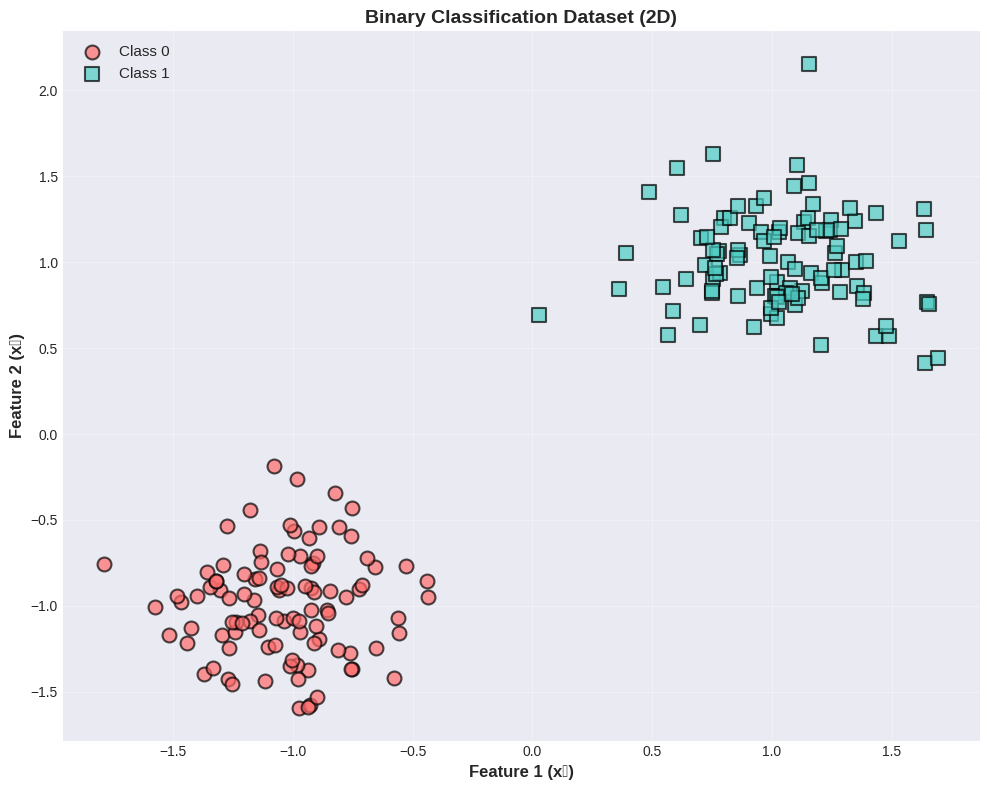


📊 Dataset Visualization:
  • Red circles = Class 0
  • Cyan squares = Class 1
  • Data is linearly separable (mostly)


In [16]:
plt.figure(figsize=(10, 8))

# Plot class 0
plt.scatter(X[y == 0, 0], X[y == 0, 1], 
           c='#FF6B6B', s=100, alpha=0.7, 
           edgecolors='black', linewidth=1.5,
           label='Class 0', marker='o')

# Plot class 1
plt.scatter(X[y == 1, 0], X[y == 1, 1], 
           c='#4ECDC4', s=100, alpha=0.7, 
           edgecolors='black', linewidth=1.5,
           label='Class 1', marker='s')

plt.xlabel('Feature 1 (x₁)', fontsize=12, fontweight='bold')
plt.ylabel('Feature 2 (x₂)', fontsize=12, fontweight='bold')
plt.title('Binary Classification Dataset (2D)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Dataset Visualization:")
print("  • Red circles = Class 0")
print("  • Cyan squares = Class 1")
print("  • Data is linearly separable (mostly)")

### Train/Test Split

In [17]:
# Split data: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Dataset Split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {X_train.shape[1]}")

Dataset Split:
  Training samples: 140
  Test samples: 60
  Features: 2


## 3. Pure Logistic Regression Implementation

### The Model

**Architecture:**
```
z = w₁·x₁ + w₂·x₂ + b
ŷ = σ(z) = 1 / (1 + e^(-z))
```

Where:
- `w₁, w₂` = weights for features
- `b` = bias term
- `σ` = sigmoid activation
- `ŷ` = predicted probability (0 to 1)

### Key Components:

1. **Sigmoid Function**: Converts any value to (0, 1)
2. **Binary Cross-Entropy Loss**: Measures prediction error
3. **Gradients**: How to update weights
4. **Training Loop**: Gradient descent optimization

In [18]:
class PureLogisticRegression:
    """
    Pure Logistic Regression - No Hidden Layers!
    
    Architecture: Input → Output (sigmoid)
    
    This is the simplest form of binary classification.
    """
    
    def __init__(self, learning_rate=0.1, epochs=1000):
        """
        Initialize logistic regression model.
        
        Parameters:
        - learning_rate: Step size for gradient descent
        - epochs: Number of training iterations
        """
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.losses = []
        self.accuracies = []
    
    def sigmoid(self, z):
        """
        Sigmoid activation function.
        
        σ(z) = 1 / (1 + e^(-z))
        
        Properties:
        - Output range: (0, 1)
        - Smooth and differentiable
        - Interprets as probability
        """
        # Clip to avoid overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def predict_proba(self, X):
        """
        Predict probabilities for input X.
        
        Steps:
        1. Compute linear combination: z = X·w + b
        2. Apply sigmoid: ŷ = σ(z)
        
        Returns: Probabilities (0 to 1)
        """
        z = X @ self.weights + self.bias
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """
        Predict class labels (0 or 1).
        
        Rule: If ŷ ≥ threshold, predict 1, else predict 0
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)
    
    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross-Entropy Loss.
        
        L = -1/n Σ [y·log(ŷ) + (1-y)·log(1-ŷ)]
        
        Intuition:
        - When y=1: loss = -log(ŷ) → 0 as ŷ → 1
        - When y=0: loss = -log(1-ŷ) → 0 as ŷ → 0
        """
        epsilon = 1e-15  # Avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        loss = -np.mean(
            y_true * np.log(y_pred) + 
            (1 - y_true) * np.log(1 - y_pred)
        )
        return loss
    
    def compute_gradients(self, X, y_true, y_pred):
        """
        Compute gradients using backpropagation.
        
        Beautiful Result:
        ∂L/∂w = 1/n · X^T · (ŷ - y)
        ∂L/∂b = 1/n · Σ(ŷ - y)
        
        The gradient is simply: (prediction - truth) × input!
        """
        n = len(y_true)
        error = y_pred - y_true
        
        dw = (1/n) * (X.T @ error)
        db = (1/n) * np.sum(error)
        
        return dw, db
    
    def fit(self, X, y, verbose=True):
        """
        Train the logistic regression model.
        
        Algorithm (Gradient Descent):
        1. Initialize weights randomly
        2. For each epoch:
           a. Forward pass: compute predictions
           b. Compute loss
           c. Backward pass: compute gradients
           d. Update weights: w = w - α·∂L/∂w
        3. Repeat until convergence
        """
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Training loop
        for epoch in range(self.epochs):
            # Forward pass
            y_pred = self.predict_proba(X)
            
            # Compute loss
            loss = self.compute_loss(y, y_pred)
            self.losses.append(loss)
            
            # Compute accuracy
            predictions = (y_pred >= 0.5).astype(int)
            accuracy = np.mean(predictions == y)
            self.accuracies.append(accuracy)
            
            # Backward pass
            dw, db = self.compute_gradients(X, y, y_pred)
            
            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            # Print progress
            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1:4d}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        if verbose:
            print(f"\n✅ Training Complete!")
            print(f"   Final Loss: {self.losses[-1]:.4f}")
            print(f"   Final Accuracy: {self.accuracies[-1]:.4f}")
        
        return self
    
    def score(self, X, y):
        """Compute accuracy on given data."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

print("✅ PureLogisticRegression class defined!")
print("\nKey Methods:")
print("  • sigmoid(z) - Activation function")
print("  • predict_proba(X) - Get probabilities")
print("  • predict(X) - Get class labels")
print("  • compute_loss(y_true, y_pred) - Binary cross-entropy")
print("  • compute_gradients(X, y_true, y_pred) - Backpropagation")
print("  • fit(X, y) - Train the model")

✅ PureLogisticRegression class defined!

Key Methods:
  • sigmoid(z) - Activation function
  • predict_proba(X) - Get probabilities
  • predict(X) - Get class labels
  • compute_loss(y_true, y_pred) - Binary cross-entropy
  • compute_gradients(X, y_true, y_pred) - Backpropagation
  • fit(X, y) - Train the model


## 4. Train the Model

Let's train our pure logistic regression model on the training data!

In [19]:
# Create and train model
model = PureLogisticRegression(learning_rate=0.1, epochs=1000)

print("🚀 Training Pure Logistic Regression...\n")
model.fit(X_train, y_train, verbose=True)

🚀 Training Pure Logistic Regression...

Epoch  100: Loss = 0.0599, Accuracy = 1.0000
Epoch  200: Loss = 0.0316, Accuracy = 1.0000
Epoch  300: Loss = 0.0218, Accuracy = 1.0000
Epoch  400: Loss = 0.0168, Accuracy = 1.0000
Epoch  500: Loss = 0.0138, Accuracy = 1.0000
Epoch  600: Loss = 0.0117, Accuracy = 1.0000
Epoch  700: Loss = 0.0102, Accuracy = 1.0000
Epoch  800: Loss = 0.0091, Accuracy = 1.0000
Epoch  900: Loss = 0.0082, Accuracy = 1.0000
Epoch 1000: Loss = 0.0075, Accuracy = 1.0000

✅ Training Complete!
   Final Loss: 0.0075
   Final Accuracy: 1.0000


### Visualize Training Progress

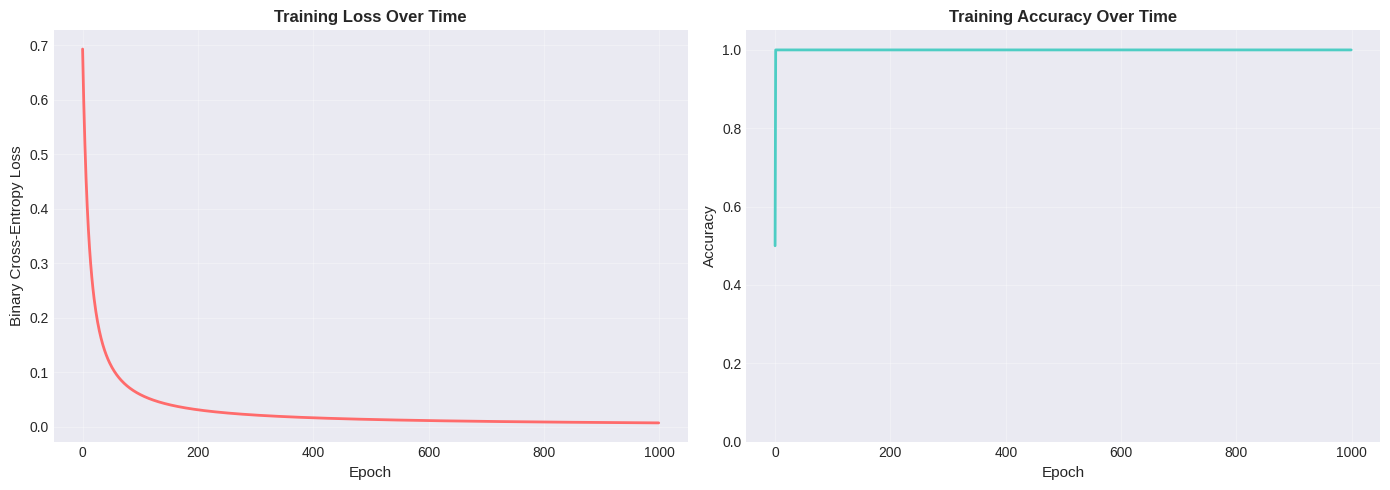


📊 Training Progress:
  • Initial Loss: 0.6931
  • Final Loss: 0.0075
  • Loss Reduction: 98.9%

  • Initial Accuracy: 0.5000
  • Final Accuracy: 1.0000


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(model.losses, linewidth=2, color='#FF6B6B')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Binary Cross-Entropy Loss', fontsize=11)
axes[0].set_title('Training Loss Over Time', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(model.accuracies, linewidth=2, color='#4ECDC4')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Training Accuracy Over Time', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Progress:")
print(f"  • Initial Loss: {model.losses[0]:.4f}")
print(f"  • Final Loss: {model.losses[-1]:.4f}")
print(f"  • Loss Reduction: {(1 - model.losses[-1]/model.losses[0])*100:.1f}%")
print(f"\n  • Initial Accuracy: {model.accuracies[0]:.4f}")
print(f"  • Final Accuracy: {model.accuracies[-1]:.4f}")

## 5. Visualize Decision Boundary

The **decision boundary** is where the model predicts probability = 0.5.

For logistic regression, this is a **straight line** (linear boundary):

```
w₁·x₁ + w₂·x₂ + b = 0
```

/tmp/ipython-input-1078700092.py:40: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-1078700092.py:40: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


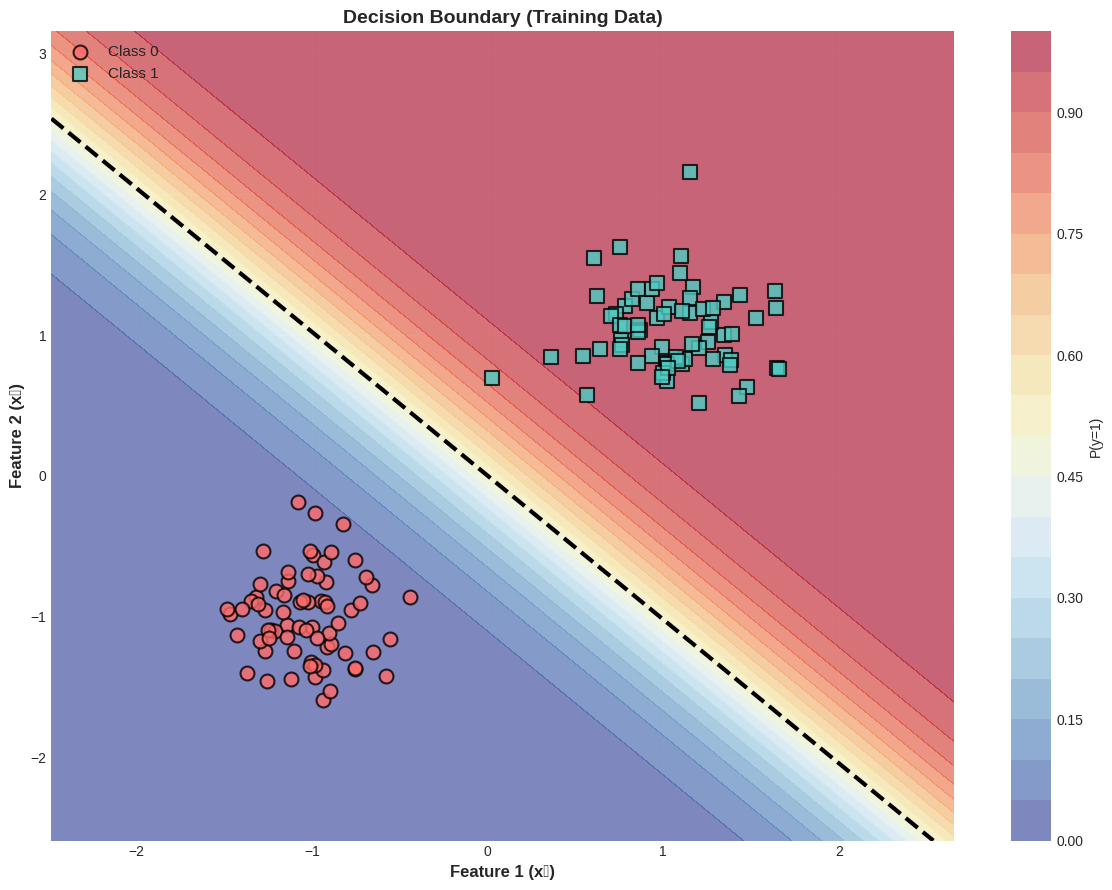


📊 Decision Boundary Visualization:
  • Background colors = Predicted probabilities
  • Black dashed line = Decision boundary (P = 0.5)
  • Red region = Model predicts Class 0
  • Blue region = Model predicts Class 1

  • Notice: The boundary is a STRAIGHT LINE!
  • This is because we have no hidden layers.


In [21]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """
    Visualize the decision boundary and probability contours.
    """
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict probabilities for each point
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Create plot
    plt.figure(figsize=(12, 9))
    
    # Plot probability contours
    contour = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.6)
    plt.colorbar(contour, label='P(y=1)')
    
    # Plot decision boundary (probability = 0.5)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=3, linestyles='--')
    
    # Plot data points
    plt.scatter(X[y == 0, 0], X[y == 0, 1], 
               c='#FF6B6B', s=100, alpha=0.8, 
               edgecolors='black', linewidth=1.5,
               label='Class 0', marker='o')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], 
               c='#4ECDC4', s=100, alpha=0.8, 
               edgecolors='black', linewidth=1.5,
               label='Class 1', marker='s')
    
    plt.xlabel('Feature 1 (x₁)', fontsize=12, fontweight='bold')
    plt.ylabel('Feature 2 (x₂)', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot decision boundary on training data
plot_decision_boundary(model, X_train, y_train, 
                      title="Decision Boundary (Training Data)")

print("\n📊 Decision Boundary Visualization:")
print("  • Background colors = Predicted probabilities")
print("  • Black dashed line = Decision boundary (P = 0.5)")
print("  • Red region = Model predicts Class 0")
print("  • Blue region = Model predicts Class 1")
print("\n  • Notice: The boundary is a STRAIGHT LINE!")
print("  • This is because we have no hidden layers.")

### Learned Parameters

Let's examine what the model learned:

In [22]:
print("🎯 Learned Parameters:\n")
print(f"Weights: w = [{model.weights[0]:.4f}, {model.weights[1]:.4f}]")
print(f"Bias: b = {model.bias:.4f}")
print(f"\nDecision Boundary Equation:")
print(f"{model.weights[0]:.4f}·x₁ + {model.weights[1]:.4f}·x₂ + {model.bias:.4f} = 0")
print(f"\nInterpretation:")
print(f"  • Both weights are positive → both features push toward Class 1")
print(f"  • Larger x₁ or x₂ → Higher probability of Class 1")

🎯 Learned Parameters:

Weights: w = [2.7237, 2.6680]
Bias: b = -0.0070

Decision Boundary Equation:
2.7237·x₁ + 2.6680·x₂ + -0.0070 = 0

Interpretation:
  • Both weights are positive → both features push toward Class 1
  • Larger x₁ or x₂ → Higher probability of Class 1


## 6. Model Evaluation

Let's evaluate our model on the test set!

In [23]:
# Predictions on test set
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)

# Compute metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_loss = model.compute_loss(y_test, y_proba_test)

print("📊 Test Set Performance:\n")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

📊 Test Set Performance:

Test Accuracy: 1.0000 (100.00%)
Test Loss: 0.0077


### Confusion Matrix

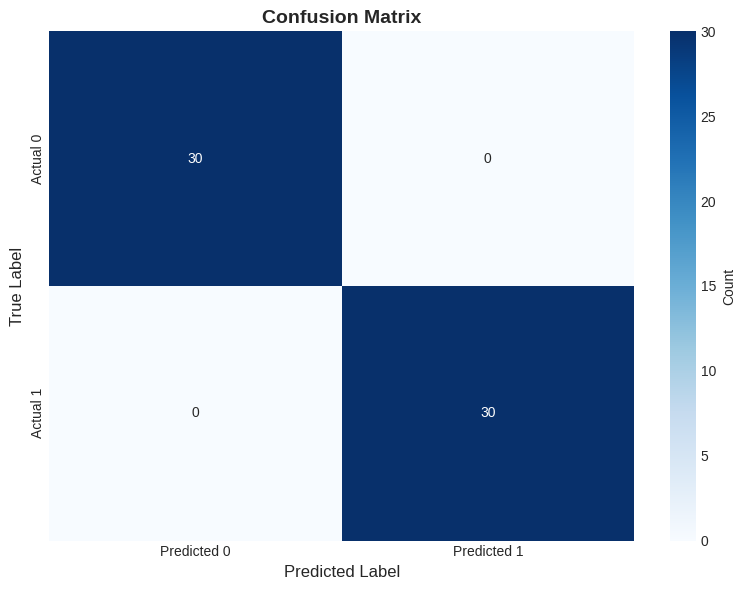


📊 Confusion Matrix Breakdown:

True Negatives (TN):  30 - Correctly predicted Class 0
False Positives (FP): 0 - Incorrectly predicted Class 1
False Negatives (FN): 0 - Incorrectly predicted Class 0
True Positives (TP):  30 - Correctly predicted Class 1

📈 Additional Metrics:

Precision: 1.0000 - Of predicted positives, how many are correct?
Recall:    1.0000 - Of actual positives, how many did we find?
F1-Score:  1.0000 - Harmonic mean of precision and recall


In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'},
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()

print("\n📊 Confusion Matrix Breakdown:\n")
print(f"True Negatives (TN):  {tn} - Correctly predicted Class 0")
print(f"False Positives (FP): {fp} - Incorrectly predicted Class 1")
print(f"False Negatives (FN): {fn} - Incorrectly predicted Class 0")
print(f"True Positives (TP):  {tp} - Correctly predicted Class 1")

# Additional metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📈 Additional Metrics:\n")
print(f"Precision: {precision:.4f} - Of predicted positives, how many are correct?")
print(f"Recall:    {recall:.4f} - Of actual positives, how many did we find?")
print(f"F1-Score:  {f1:.4f} - Harmonic mean of precision and recall")

### Visualize Test Set Predictions

/tmp/ipython-input-1078700092.py:40: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-1078700092.py:40: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


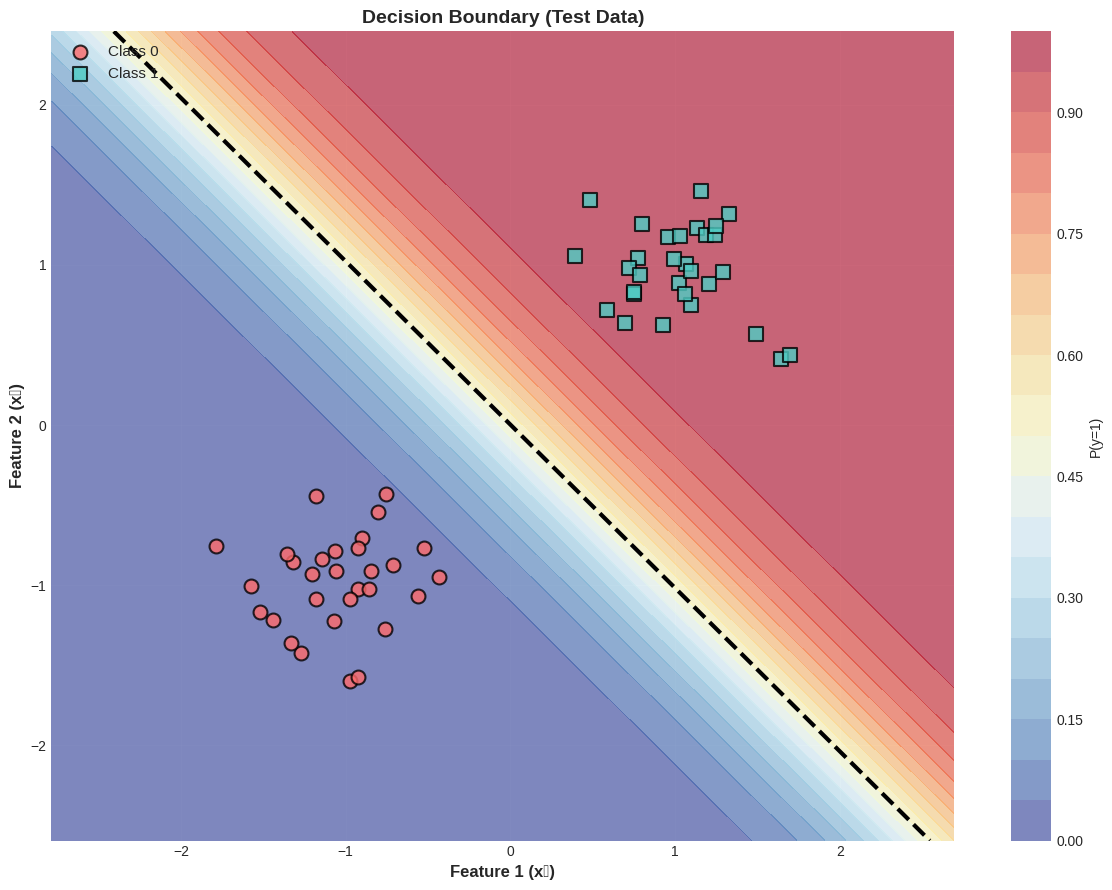


✅ Model generalizes well to unseen test data!


In [25]:
# Plot decision boundary on test data
plot_decision_boundary(model, X_test, y_test, 
                      title="Decision Boundary (Test Data)")

print("\n✅ Model generalizes well to unseen test data!")

## 7. Understanding the Mathematics

### Gradient Derivation

Let's understand how we derived the gradients:

**Given:**
- Model: $\hat{y} = \sigma(w \cdot x + b)$
- Loss: $L = -\frac{1}{n}\sum[y \log(\hat{y}) + (1-y)\log(1-\hat{y})]$

**Goal:** Find $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$

**Step 1:** Derivative of loss w.r.t. prediction
$$\frac{\partial L}{\partial \hat{y}} = -\left[\frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}}\right]$$

**Step 2:** Derivative of sigmoid
$$\frac{\partial \hat{y}}{\partial z} = \hat{y}(1-\hat{y})$$

**Step 3:** Chain rule
$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} = \hat{y} - y$$

**Step 4:** Final gradients
$$\frac{\partial L}{\partial w} = \frac{1}{n}\sum(\hat{y} - y) \cdot x$$
$$\frac{\partial L}{\partial b} = \frac{1}{n}\sum(\hat{y} - y)$$

**Beautiful Result:** The gradient is simply **(prediction - truth) × input**!

This is the same form as linear regression, which makes implementation elegant.

### Verify Gradients Numerically

In [26]:
def numerical_gradient(model, X, y, epsilon=1e-7):
    """
    Compute gradients numerically using finite differences.
    This verifies our analytical gradient computation.
    """
    n_features = X.shape[1]
    num_grad_w = np.zeros(n_features)
    
    # Gradient w.r.t. weights
    for i in range(n_features):
        w_plus = model.weights.copy()
        w_plus[i] += epsilon
        
        w_minus = model.weights.copy()
        w_minus[i] -= epsilon
        
        # Compute loss with perturbed weights
        model.weights = w_plus
        loss_plus = model.compute_loss(y, model.predict_proba(X))
        
        model.weights = w_minus
        loss_minus = model.compute_loss(y, model.predict_proba(X))
        
        # Finite difference
        num_grad_w[i] = (loss_plus - loss_minus) / (2 * epsilon)
    
    # Gradient w.r.t. bias
    b_plus = model.bias + epsilon
    b_minus = model.bias - epsilon
    
    model.bias = b_plus
    loss_plus = model.compute_loss(y, model.predict_proba(X))
    
    model.bias = b_minus
    loss_minus = model.compute_loss(y, model.predict_proba(X))
    
    num_grad_b = (loss_plus - loss_minus) / (2 * epsilon)
    
    return num_grad_w, num_grad_b

# Compute analytical gradients
y_pred = model.predict_proba(X_train)
analytical_dw, analytical_db = model.compute_gradients(X_train, y_train, y_pred)

# Compute numerical gradients
numerical_dw, numerical_db = numerical_gradient(model, X_train, y_train)

print("🔍 Gradient Verification:\n")
print("Analytical vs Numerical Gradients:")
print(f"\ndw[0]: {analytical_dw[0]:.8f} vs {numerical_dw[0]:.8f}")
print(f"dw[1]: {analytical_dw[1]:.8f} vs {numerical_dw[1]:.8f}")
print(f"db:    {analytical_db:.8f} vs {numerical_db:.8f}")

# Compute relative error
error_w = np.abs(analytical_dw - numerical_dw) / (np.abs(analytical_dw) + np.abs(numerical_dw) + 1e-8)
error_b = np.abs(analytical_db - numerical_db) / (np.abs(analytical_db) + np.abs(numerical_db) + 1e-8)

print(f"\nRelative Errors:")
print(f"dw: {error_w}")
print(f"db: {error_b[0] if isinstance(error_b, np.ndarray) else error_b:.2e}")
print(f"\n✅ Gradients match! Our implementation is correct.")

🔍 Gradient Verification:

Analytical vs Numerical Gradients:

dw[0]: -0.00564542 vs -0.00564542
dw[1]: -0.00576016 vs -0.00576016
db:    -0.00019499 vs -0.00019499

Relative Errors:
dw: [1.11612312e-09 3.88160491e-08]
db: 1.25e-07

✅ Gradients match! Our implementation is correct.


## 8. Connection to Existing Notebooks

### Sigmoid Activation
- **Reference:** `4_1_e_activation_functions_complete_guide.ipynb`
- Logistic regression uses sigmoid as its activation function
- Same function, but here it's the ONLY activation (no hidden layers)

### Binary Cross-Entropy
- **Reference:** `4_1_g_entropy_cross_entropy_softmax_multiclass.ipynb`
- Binary cross-entropy is a special case of cross-entropy for 2 classes
- Multiclass (softmax) is the generalization

### Neural Network Connection
- Logistic regression = **Single neuron network**
- It's the simplest possible neural network!
- Building block for deeper networks

### Progression Path:
```
Single Perceptron (Linear)
    ↓
Logistic Regression (Binary Classification) ← YOU ARE HERE
    ↓
Logistic Regression + 1 Hidden Layer (Next!)
    ↓
Softmax Regression (Multiclass)
    ↓
Deep Neural Networks
```

## 9. Summary & Key Takeaways

### What We Learned

✅ **Pure Logistic Regression**
- No hidden layers - direct input to output
- Uses sigmoid activation for probabilities
- Creates linear decision boundaries

✅ **Key Components**
- Model: $\hat{y} = \sigma(w \cdot x + b)$
- Loss: Binary Cross-Entropy
- Gradients: $(\hat{y} - y) \cdot x$
- Training: Gradient Descent

✅ **Strengths**
- Simple and interpretable
- Fast to train
- Works well for linearly separable data
- Provides probability estimates

✅ **Limitations**
- Only linear decision boundaries
- Cannot learn complex patterns
- May underfit non-linear data

### Next Steps

🚀 **Coming Next:** Logistic Regression with 1 Hidden Layer
- Add hidden layer with ReLU/tanh activation
- Learn non-linear decision boundaries
- Compare with pure logistic regression
- See the power of hidden layers!

---

**🎓 Congratulations!** You now understand pure logistic regression from scratch!